this script is for visualizing the results from the case study

In [36]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [37]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty, game_is_superadditive
from src.nucleolus import get_nucleolus
from src.least_core_nucleolus import get_least_core_nucleolus

In [38]:
def make_game_superadditive(v: dict, players: list) -> dict:
    """
    make game superadditive by adjusting values of coalitions

    v: Characteristic function of the game, must be defined for EVERY coalition
        {frozenset -> float}
    players: list of players
    """
    v_superadd = v.copy()
    for S in powerset(players, exclude_empty=True):
        T = frozenset(players) - S
        union = S.union(T)
        if v_superadd[union] < v_superadd[S] + v_superadd[T]:
            v_superadd[union] = v_superadd[S] + v_superadd[T]
    return v_superadd

In [39]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\536717058.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [40]:
services = ['FFR-FCR']  # list of services to visualize
dvpps_infos = {}  # dictionary to hold dvpp info dataframes
main_paths = ['pics/v_case_0604/', 'pics/v_case_0704/', 'pics/v_case/']
main_path = 'pics/v_case_combined/'
df_expected = pd.DataFrame()
df_realized = pd.DataFrame()
dvpp_info = pd.DataFrame()
df_bids = pd.DataFrame()

df_expected = pd.read_csv(f'{main_path}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_expected.columns = [tuple(c for c in col if c!='nan') for col in df_expected.columns.values]
df_realized = pd.read_csv(f'{main_path}values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_realized.columns = [tuple(c for c in col if c!='nan') for col in df_realized.columns.values]
for service in services:
    dvpps_infos[service] = pd.read_csv(f'{main_path}dvpp_info_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

## option to merge folders

In [41]:
# # quicklt merge the files in v_case
# for main_path in main_paths:
#     df_expected_tmp = pd.read_csv(f'{main_path}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
#     # df_expected_tmp.columns = [tuple(c for c in col if c!='nan') for col in df_expected_tmp.columns.values]
#     df_realized_tmp = pd.read_csv(f'{main_path}values_DPF.csv', index_col=[0,1], header=[0,1,2])
#     # df_realized_tmp.columns = [tuple(c for c in col if c!='nan') for col in df_realized_tmp.columns.values]
#     df_expected = pd.concat([df_expected, df_expected_tmp])
#     df_realized = pd.concat([df_realized, df_realized_tmp])
#     # also do for dvpp_info_DPF_FFR-FCR
#     dvpp_info_tmp = pd.read_csv(f'{main_path}dvpp_info_DPF_FFR-FCR.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
#     dvpp_info = pd.concat([dvpp_info, dvpp_info_tmp])
#     # also for bids
#     # df_bids = pd.read_csv(f'{main_path}/bids_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
#     df_bids_tmp = pd.read_csv(f'{main_path}bids_DPF_FFR-FCR.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
#     df_bids = pd.concat([df_bids, df_bids_tmp])

In [42]:
# # change index for df_expected
# new_index = pd.MultiIndex.from_product((['FFR-FCR'], np.arange(len(df_expected))))
# df_expected.index = new_index
# df_realized.index = new_index

In [43]:
# # save in folder
# main_path = 'pics/v_case_combined/'
# df_expected.to_csv(f'{main_path}expected_values_DPF.csv')
# df_realized.to_csv(f'{main_path}values_DPF.csv')
# dvpp_info.to_csv(f'{main_path}dvpp_info_DPF_FFR-FCR.csv')
# df_bids.to_csv(f'{main_path}bids_DPF_FFR-FCR.csv')

# Reward Split

## Pure-Nucleolus Reward Split

In [44]:
# get reward split of devices
players = [c[0] for c in df_expected.columns if len(c)==1]
idxes = pd.MultiIndex.from_product((df_expected.index.get_level_values(1), ['E-Value', 'E-Nucleolus', 'R-Value', 'R-Nucleolus']))
df_reward_split = pd.DataFrame(0.0, index=idxes, columns=players)
superadditivity_counter = 0
convexity_counter = 0
core_non_empty_counter = 0
for idx, row in df_expected.iterrows():
    # 1. Expected game convert to dictionary
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    # v = make_game_superadditive(v, players)  # ensure superadditivity
    if game_is_superadditive(v, players):
        superadditivity_counter += 1
        nucleolus = get_nucleolus(v, players)
    else:
        print(f"for time {idx[0]}, expected game is not superadditive.")
        print(v)
        nucleolus = get_least_core_nucleolus(v, players)
    if is_convex_game(v, players):
        convexity_counter += 1
    if core_nonempty(v, players):
        core_non_empty_counter += 1
    df_reward_split.loc[(idx[1], 'E-Nucleolus'), list(k for k in nucleolus.keys())] = list(nucleolus.values())
    df_reward_split.loc[(idx[1], 'E-Value'), list(p for p in players)] = [v[frozenset({p})] for p in players]
    # 2. Realized game convert to dictionary
    v_realized = {frozenset(k): val for k, val in df_realized.loc[idx].items()}
    v_realized[frozenset()] = 0.0  # ensure empty set
    nucleolus_realized = get_least_core_nucleolus(v_realized, players)
    df_reward_split.loc[(idx[1], 'R-Nucleolus'), list(k for k in nucleolus_realized.keys())] = list(nucleolus_realized.values())
    df_reward_split.loc[(idx[1], 'R-Value'), list(p for p in players)] = [v_realized[frozenset({p})] for p in players]

for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV'}): 1.08426, frozenset({'Wind'}): 1.19386, frozenset({'BESS'}): 0.0, frozenset({'PV', 'Wind'}): 2.23926, frozenset({'PV', 'BESS'}): 2.72833, frozenset({'Wind', 'BESS'}): 3.73485, frozenset({'PV', 'Wind', 'BESS'}): 6.60369, frozenset(): 0.0}
for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV'}): 0.30697, frozenset({'Wind'}): 0.06578, frozenset({'BESS'}): 0.0, frozenset({'PV', 'Wind'}): 0.36636, frozenset({'PV', 'BESS'}): 0.77242, frozenset({'Wind', 'BESS'}): 0.20578, frozenset({'PV', 'Wind', 'BESS'}): 1.02185, frozenset(): 0.0}
for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV'}): 1.4768, frozenset({'Wind'}): 0.05355, frozenset({'BESS'}): 0.0, frozenset({'PV', 'Wind'}): 1.40456, frozenset({'PV', 'BESS'}): 3.71608, frozenset({'Wind', 'BESS'}): 0.16098, frozenset({'PV', 'Wind', 'BESS'}): 3.71608, frozenset(): 0.0}
for time FFR-FCR, expected game is not superadditive.
{frozenset({'P

In [45]:
print(f"For {main_path}, out of {len(df_expected)} games, {superadditivity_counter} superadditive, {convexity_counter} convex and {core_non_empty_counter} non-empty core.") 

For pics/v_case_combined/, out of 163 games, 106 superadditive, 80 convex and 135 non-empty core.


# Reward Split with New Method

In [67]:
from src.game_theory_helpers import evaluate_full_game, solve_optimal_partition

In [68]:
def evaluate_full_game(df_forecasted: pd.DataFrame,
                       df_realized: pd.DataFrame) -> pd.DataFrame:
    # create output df
    index = pd.MultiIndex.from_product([df_forecasted.index.get_level_values(1), ['Forecasted', 'Realized'], ['Value', 'Reward']],)
    # Method can be: ['Shapley', 'Nucleolus', 'Sub-Game']
    player_cols = [c for c in df_forecasted.columns if len(c)==1]  # devices cols
    players = [c[0] for c in df_forecasted.columns if len(c)==1]  # devices
    columns = players + ['Method', 'Method-Realized']
    df = pd.DataFrame(pd.NA, index=index, columns=columns)  # all coalition
    
    for idx, row in df_forecasted.iterrows():
        realized_row = df_realized.loc[idx]
        idx = idx[1]  # adjust index
        df.loc[(idx, 'Forecasted', 'Value'), players] = row[player_cols].values  # add row to output
        v = {frozenset(k): val for k, val in row.items()}  # create value function
        v[frozenset()] = 0
        # get realized values
        df.loc[(idx, 'Realized', 'Value'), players] = realized_row[player_cols].values  # add realized row to output
        v_realized = {frozenset(k): val for k, val in realized_row.items()}  # create value function
        v_realized[frozenset()] = 0
        # check if convex
        if is_convex_game(v, players):
            df.loc[idx, 'Method'] = 'Shapley'
            shapley = get_shapley_value(v, players)
            df.loc[(idx, 'Forecasted', 'Reward'), list(shapley.keys())] = list(shapley.values())
            shapley = get_shapley_value(v_realized, players)
            df.loc[(idx, 'Realized', 'Reward'), list(shapley.keys())] = list(shapley.values())
        # elif check if core non-empty or superadditive
        elif game_is_superadditive(v, players) or core_nonempty(v, players):
            df.loc[idx, 'Method'] = 'Nucleolus'
            # get nucleolus
            nucleolus = get_nucleolus(v, players)
            df.loc[(idx, 'Forecasted', 'Reward'), list(nucleolus.keys())] = list(nucleolus.values())
            # get least core nucleolus as the game may be empty core / not superadditive
            nucleolus = get_least_core_nucleolus(v_realized, players)
            df.loc[(idx, 'Realized', 'Reward'), list(nucleolus.keys())] = list(nucleolus.values())
        else:
            df.loc[idx, 'Method'] = 'Sub-Game'
            # form sub-games
            max_value, coalitions = solve_optimal_partition(v)
            for coalition in coalitions:
                # iterate over coalitions and compute optimal value
                sub_game_value = v[coalition]
                if len(coalition) == 1:
                    # if single device, just assign its value
                    df.loc[(idx, 'Forecasted', 'Reward'), tuple(coalition)[0]] = sub_game_value
                    df.loc[(idx, 'Realized', 'Reward'), tuple(coalition)[0]] = v_realized[coalition]
                else:
                    v_subgame = {k: val for k, val in v.items() if k.issubset(coalition)}
                    v_subgame[frozenset()] = 0
                    if is_convex_game(v_subgame, list(coalition)):
                        shapley_sub = get_shapley_value(v_subgame, list(coalition))
                        for p, val in shapley_sub.items():
                            df.loc[(idx, 'Forecasted', 'Reward'), p] = val
                        shapley_sub = get_shapley_value({k: val for k, val in v_realized.items() if k.issubset(coalition)}, list(coalition))
                        for p, val in shapley_sub.items(): 
                            df.loc[(idx, 'Realized', 'Reward'), p] = val
                    else:
                        nucleolus_sub = get_nucleolus(v_subgame, list(coalition))
                        for p, val in nucleolus_sub.items():
                            df.loc[(idx, 'Forecasted', 'Reward'), p] = val
                        nucleolus_sub = get_least_core_nucleolus({k: val for k, val in v_realized.items() if k.issubset(coalition)}, list(coalition))
                        for p, val in nucleolus_sub.items(): 
                            df.loc[(idx, 'Realized', 'Reward'), p] = val
        # also calculated realized game Shapley / Nucleolus / Sub-Game
        if is_convex_game(v_realized, players):
            df.loc[idx, 'Method-Realized'] = 'Shapley'
        elif game_is_superadditive(v_realized, players) or core_nonempty(v_realized, players):
            df.loc[idx, 'Method-Realized'] = 'Nucleolus'
        else:
            df.loc[idx, 'Method-Realized'] = 'Sub-Game'
    return df

In [69]:
df_rewards = evaluate_full_game(df_expected, df_realized)

In [70]:
hours = df_rewards.index.get_level_values(0).unique()
print(df_rewards.loc[(hours, 'Realized', 'Reward'), 'Method'].value_counts())
print(f"out of {len(hours)}.")

Method
Shapley      80
Nucleolus    55
Sub-Game     28
Name: count, dtype: int64
out of 163.


In [71]:
# also show realized game
print(df_rewards.loc[(hours, 'Realized', 'Reward'), 'Method-Realized'].value_counts())
print(f"out of {len(hours)}.")

Method-Realized
Shapley      69
Sub-Game     63
Nucleolus    31
Name: count, dtype: int64
out of 163.


In [49]:
# new multiindex
idxs1 = df_rewards.index.get_level_values(0).unique().values
idxs2 = df_rewards.index.get_level_values(1).unique().values
idxs3 = df_rewards.index.get_level_values(2).unique().values
idxs2_new = []
for i in idxs2:
    # append idx3
    for j in idxs3:
        idxs2_new.append(f'{i}-{j}')

In [50]:
df_rewards.index = pd.MultiIndex.from_product([idxs1, idxs2_new])

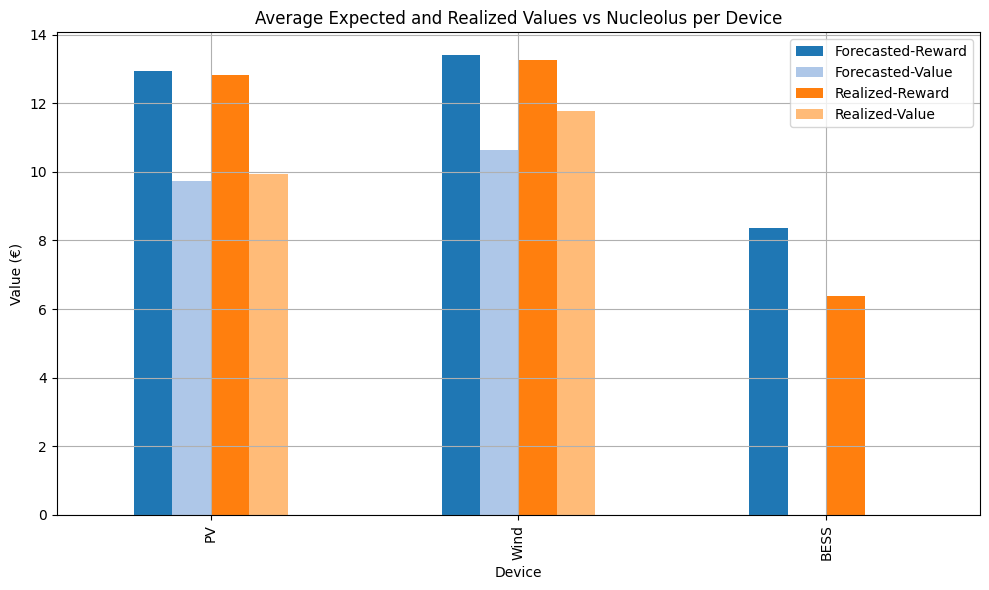

In [51]:
# plot bar chart
fig, ax = plt.subplots(figsize=(10, 6))

devices = ['PV', 'Wind', 'BESS']
df_plot = df_rewards[devices]
df_mean = df_plot.groupby(level=1).mean()
df_mean = df_mean.transpose()
df_mean.plot.bar(ax=ax)

ax.set_title('Average Expected and Realized Values vs Nucleolus per Device')
ax.set_ylabel('Value (€)')
ax.set_xlabel('Device')
ax.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [52]:
import seaborn as sns

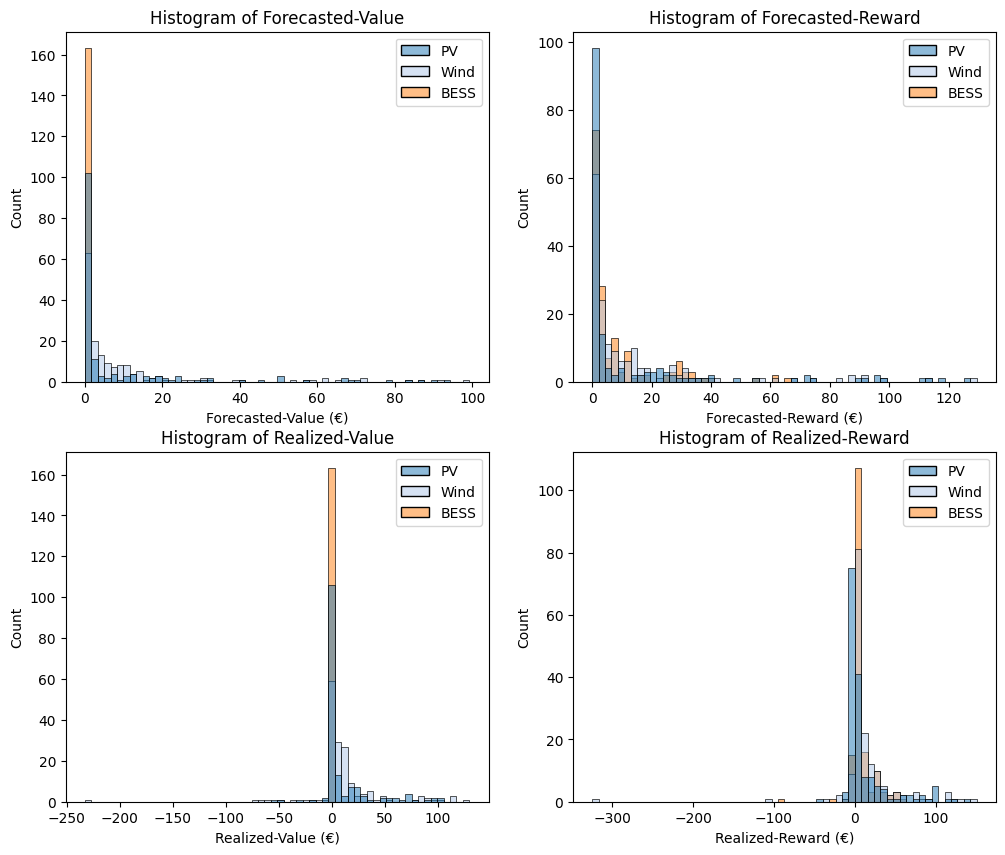

In [53]:
# make 4 subplots axis
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, x in enumerate(df_plot.index.get_level_values(1).unique().values):
    sns.histplot(df_plot.loc(axis=0)[:, x], bins=60, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'Histogram of {x}')
    axs[i//2, i%2].set_xlabel(f'{x} (€)')

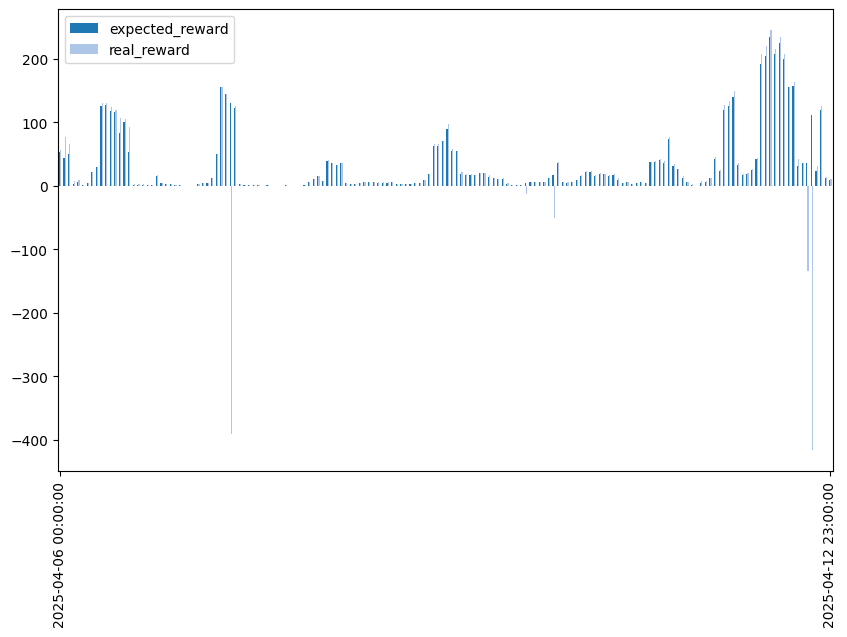

In [ ]:
df_exp_real = dvpps_infos[service].groupby(level=0)[['expected_reward', 'real_reward']].mean()
# df_exp_real['diff'] = df_exp_real['real_reward'] - df_exp_real['expected_reward']
df_exp_real.plot.bar(figsize=(10,6))
# set x axis labels as only start and end time and 5 time points in between
plt.xticks([0, len(df_exp_real)-1], [df_exp_real.index[0], df_exp_real.index[-1]])
plt.show()

### Analyze the Sub-game cases

In [55]:
from src.get_optimal_bid import get_optimal_bid
import numpy as np

In [56]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")
# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]
# Create extended cycle: first full alpha, then alpha=0.5
# colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]
# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\216728504.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [57]:
# load bids dataframe
df_bids = pd.read_csv(f'{main_path}/bids_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

In [58]:
idxs_sg = df_rewards[df_rewards['Method']=='Sub-Game'].index.get_level_values(0).unique()

In [59]:
idxs_sg

Index([  6,  30,  34,  35,  44,  50,  54,  55,  71,  74,  76,  78,  81,  83,
        97, 102, 104, 118, 120, 122, 123, 126, 128, 129, 147, 148, 149, 150],
      dtype='int64')

In [60]:
def map_idx_to_datetime(idx):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    return pd.Timestamp(vals[idx])
def map_datetime_to_idx(dt):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    for i, v in enumerate(vals):
        if v == dt:
            return i
    return None

In [61]:
def bid_value(bids, rho, bid,
              return_prob=False):
    gamma = sum(rho for b in bids if b >= bid)
    if return_prob:
        return gamma
    return bid * (4 * gamma - 3)

In [62]:
def bids_to_values(bids, rho, return_prob=False) -> np.ndarray:
    values = np.array([bid_value(bids, rho, b, return_prob=False) for b in bids])
    if not return_prob:
        return values
    else:
        gammas = np.array([bid_value(bids, rho, b, return_prob=True) for b in bids])
        return gammas, values

In [63]:
dt_idxs = [map_idx_to_datetime(i) for i in idxs_sg]

In [64]:
cols = df_bids.columns
idx_tuples = [eval(col) for col in df_bids.columns.values]
idx_frozensets = [frozenset(tup) for tup in idx_tuples]
the_map = {fs: col for fs, col in zip(idx_frozensets, cols)}

C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-06 06:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 3.76963.
Coalition frozenset({'Wind'}) max value at index 3, bid: 0.125, value: 0.050
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 3.457, value: 3.457
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 3.457, value: 3.457


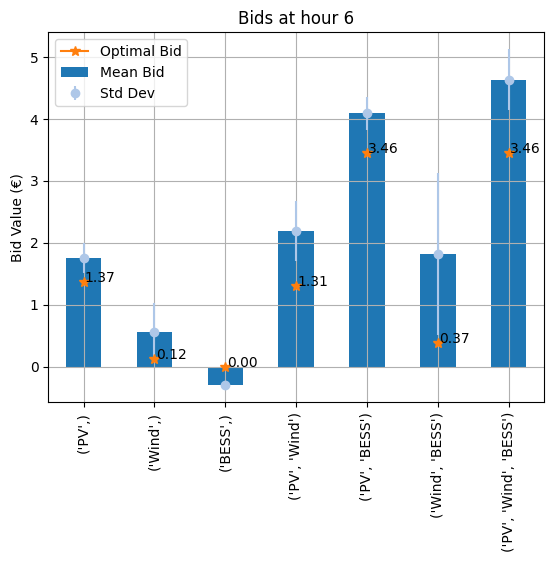

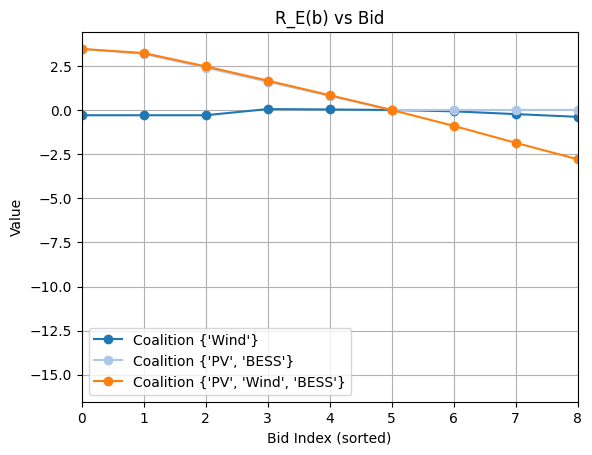

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-07 06:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 4.2260599999999995.
Coalition frozenset({'Wind'}) max value at index 4, bid: 0.188, value: 0.038
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 4.205, value: 4.205
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 4.317, value: 4.317


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


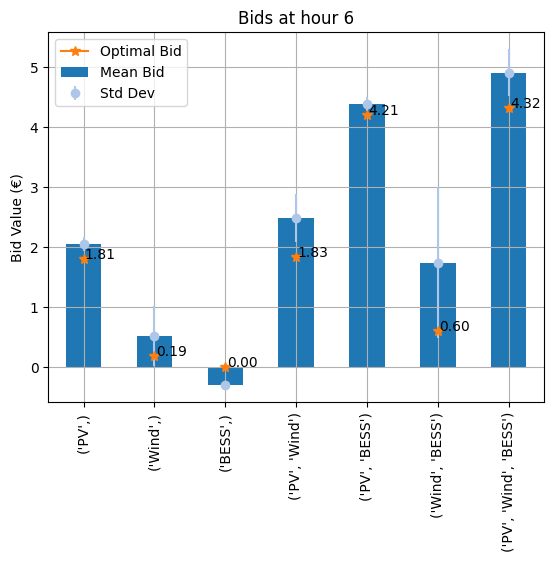

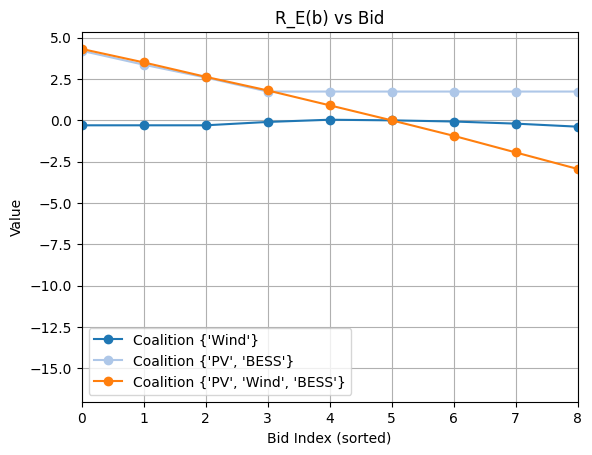

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-07 10:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 144.50525.
Coalition frozenset({'Wind'}) max value at index 3, bid: 0.577, value: 0.231
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 5.879, value: 5.879
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 6.255, value: 6.255


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


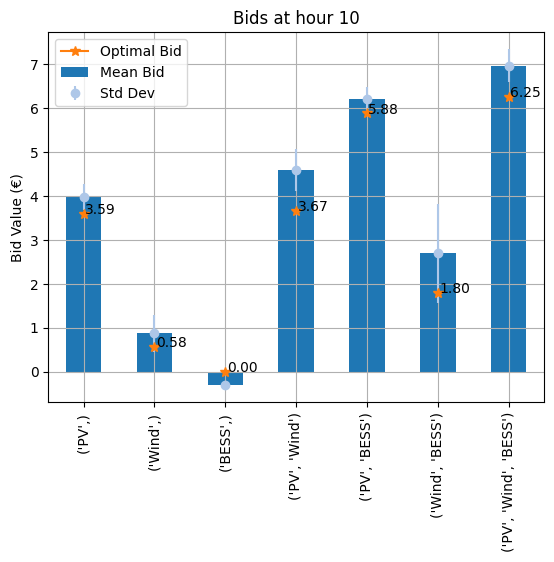

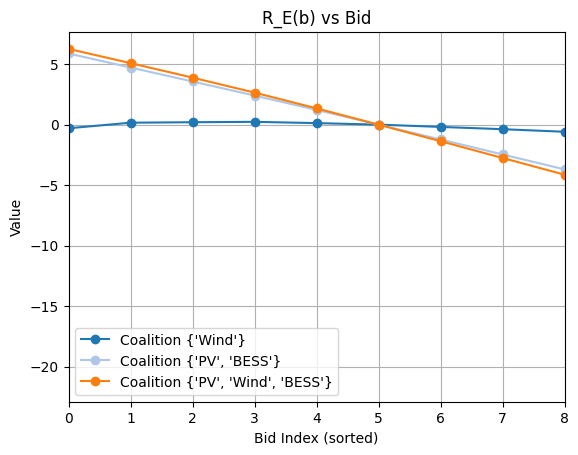

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-07 11:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 134.46372.
Coalition frozenset({'Wind'}) max value at index 4, bid: 0.599, value: 0.120
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 5.775, value: 5.775
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 6.051, value: 6.051


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


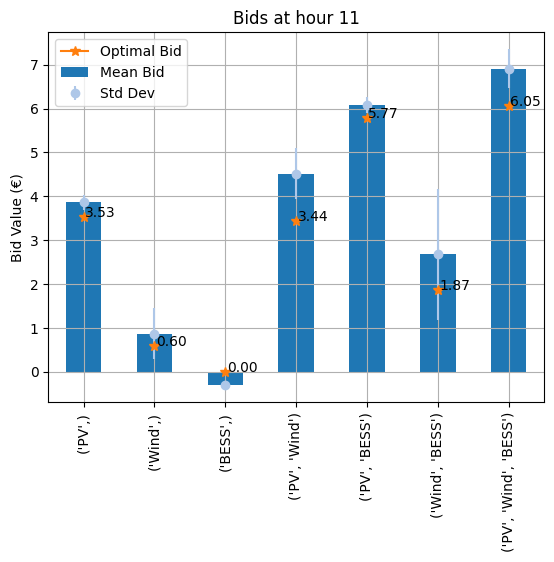

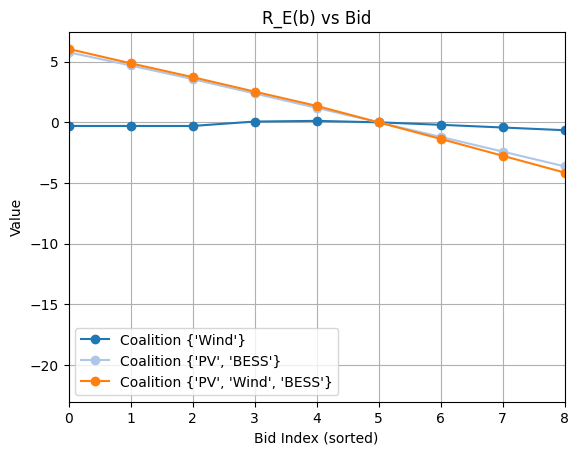

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-07 20:00:00, optimal partition is [frozenset({'PV', 'Wind'}), frozenset({'BESS'})] with value 0.04285.
Coalition frozenset({'PV', 'Wind'}) max value at index 7, bid: 0.140, value: -0.056
Coalition frozenset({'BESS'}) max value at index 0, bid: -0.300, value: -0.300
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 6, bid: -0.174, value: 0.035


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


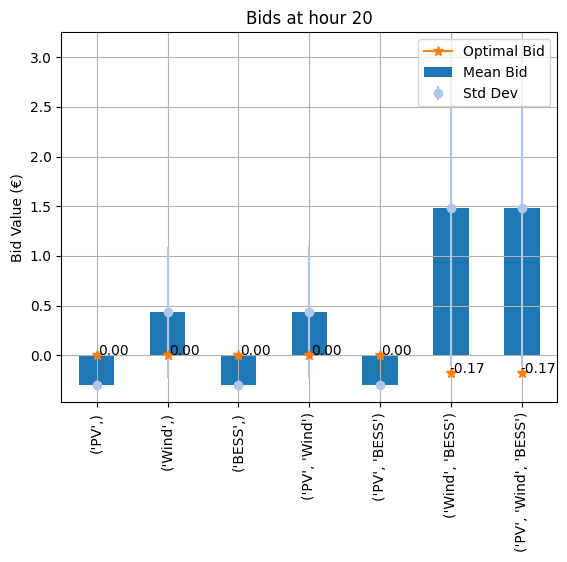

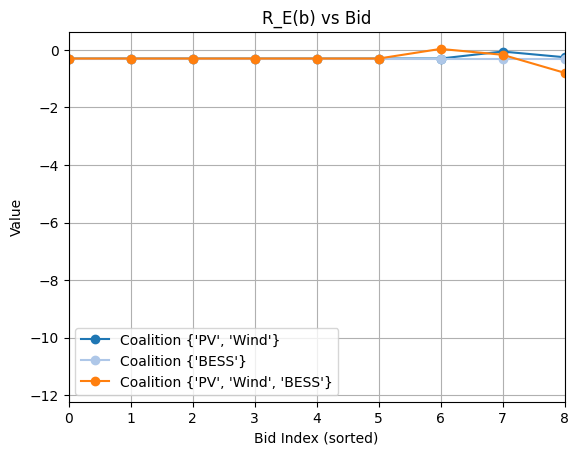

C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
At hour 2025-04-08 02:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 10.366719999999999.
Coalition frozenset({'Wind'}) max value at index 0, bid: 0.000, value: 0.000
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 0.000, value: 0.000
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 0.000, va

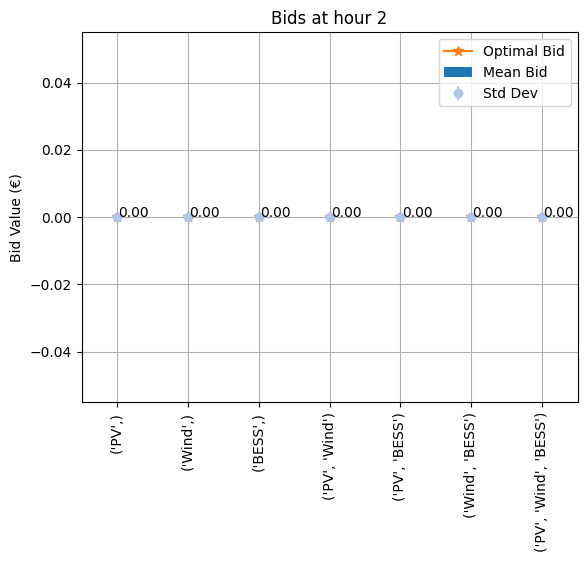

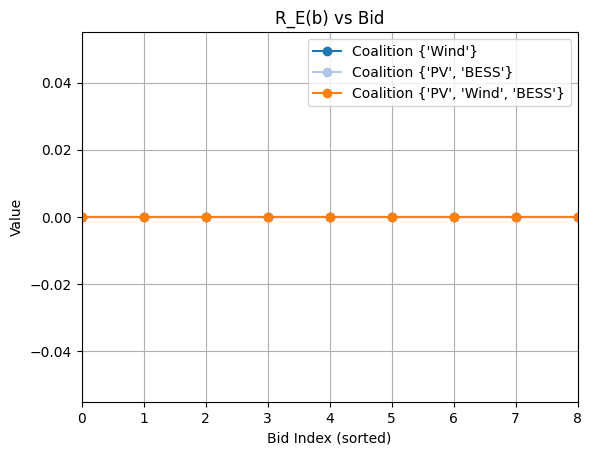

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-08 06:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 37.30278.
Coalition frozenset({'Wind'}) max value at index 1, bid: 0.878, value: 0.702
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 4.285, value: 4.285
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 5.072, value: 5.072


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


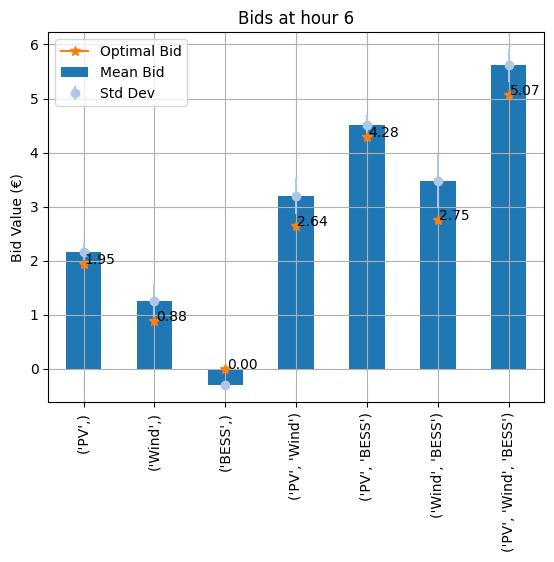

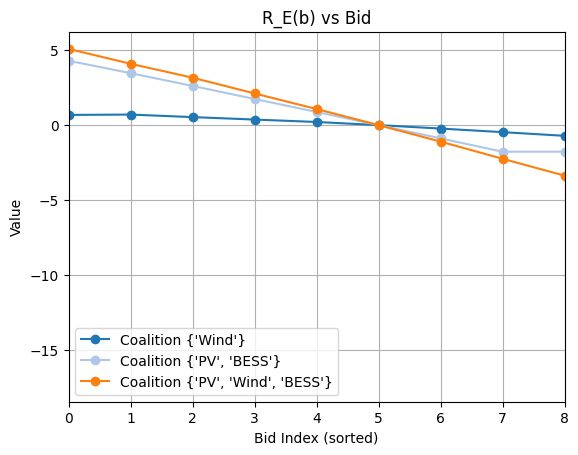

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-08 07:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 33.6589.
Coalition frozenset({'Wind'}) max value at index 2, bid: 0.536, value: 0.321
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 4.862, value: 4.862
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 4.980, value: 4.980


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


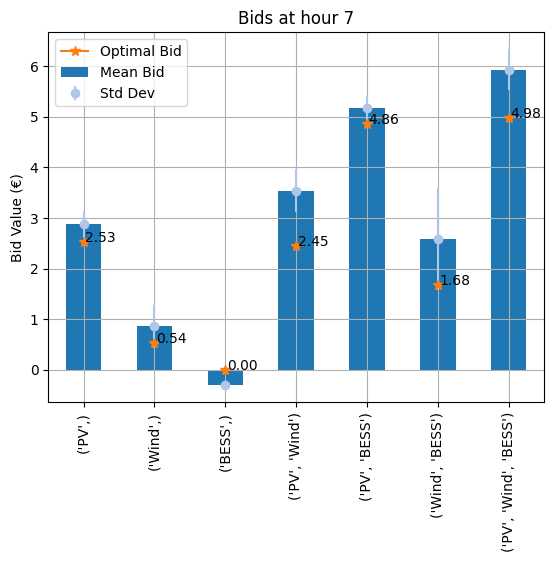

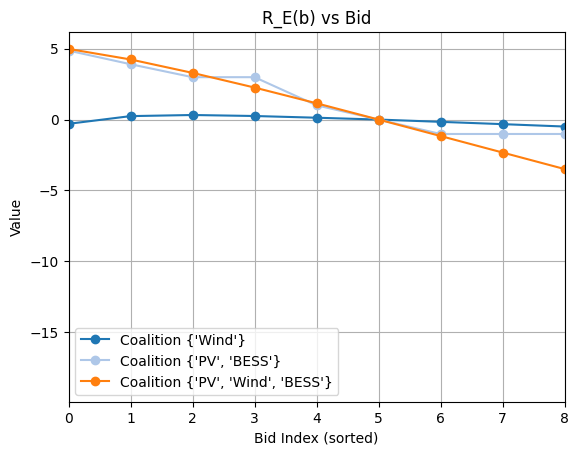

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-08 23:00:00, optimal partition is [frozenset({'Wind', 'BESS'}), frozenset({'PV'})] with value 3.2726699999999997.
Coalition frozenset({'Wind', 'BESS'}) max value at index 1, bid: 5.696, value: 4.557
Coalition frozenset({'PV'}) max value at index 0, bid: -0.300, value: -0.300
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 1, bid: 5.696, value: 4.557


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


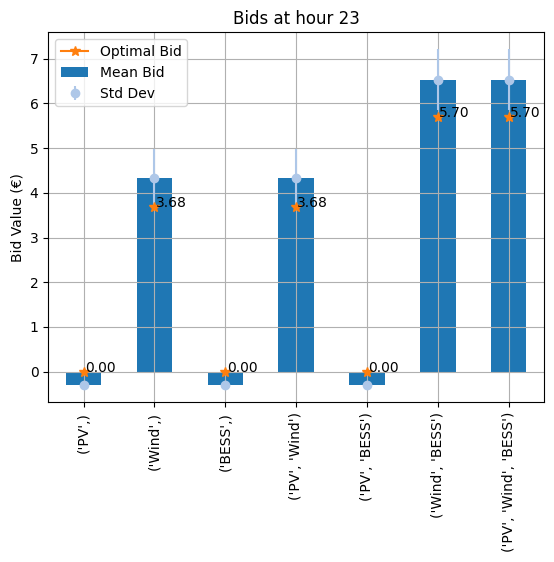

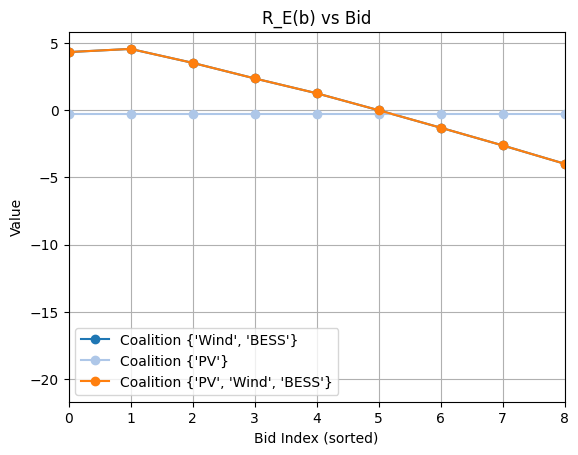

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 02:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 8.78752.
Coalition frozenset({'Wind'}) max value at index 0, bid: 4.329, value: 4.329
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: -0.300, value: -0.300
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 6.571, value: 6.571


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


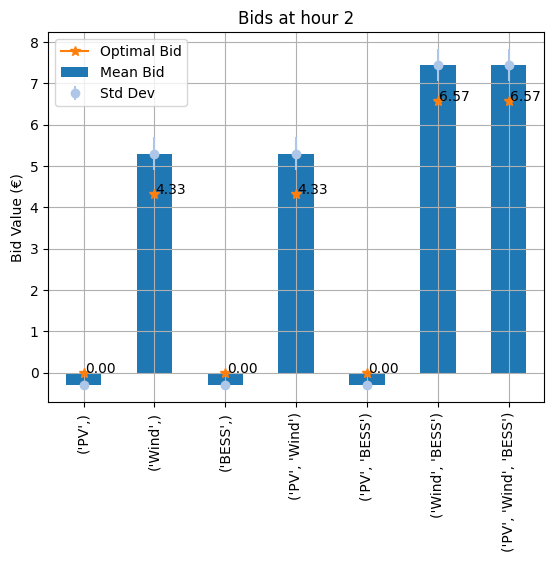

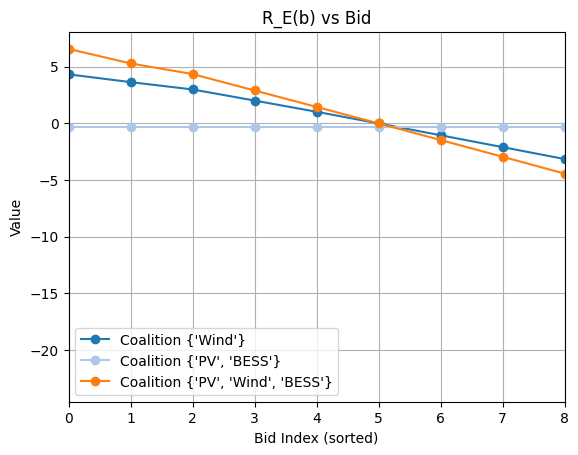

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 04:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 62.673.
Coalition frozenset({'Wind'}) max value at index 0, bid: 4.311, value: 4.311
Coalition frozenset({'PV', 'BESS'}) max value at index 1, bid: 0.418, value: 0.334
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 6.453, value: 6.453


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


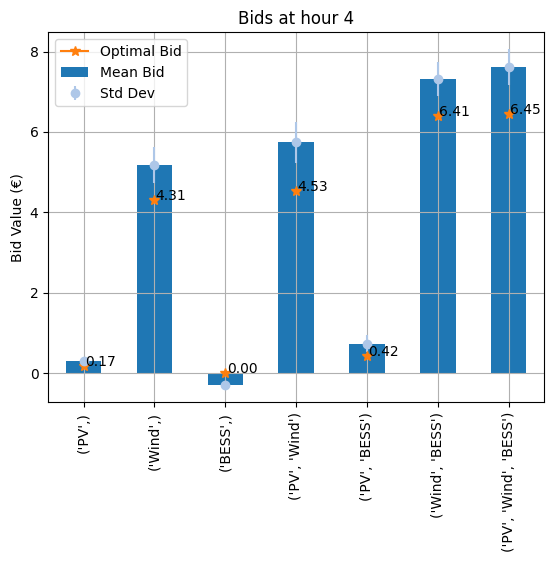

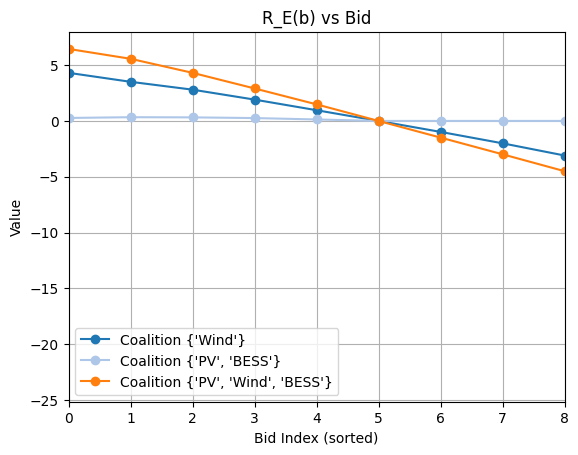

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 06:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 70.7044.
Coalition frozenset({'Wind'}) max value at index 0, bid: 4.632, value: 4.632
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 3.376, value: 3.376
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 8.324, value: 8.324


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


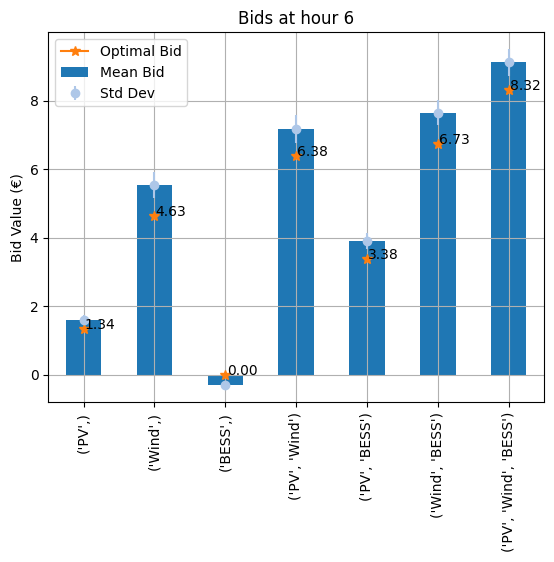

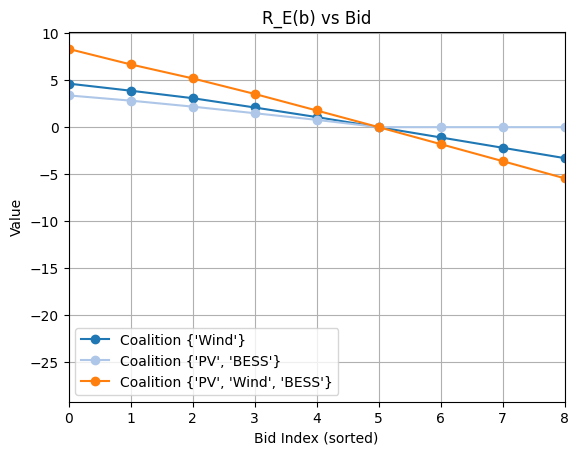

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 09:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 56.947779999999995.
Coalition frozenset({'Wind'}) max value at index 0, bid: 5.238, value: 5.238
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 5.234, value: 5.234
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 10.374, value: 10.374


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


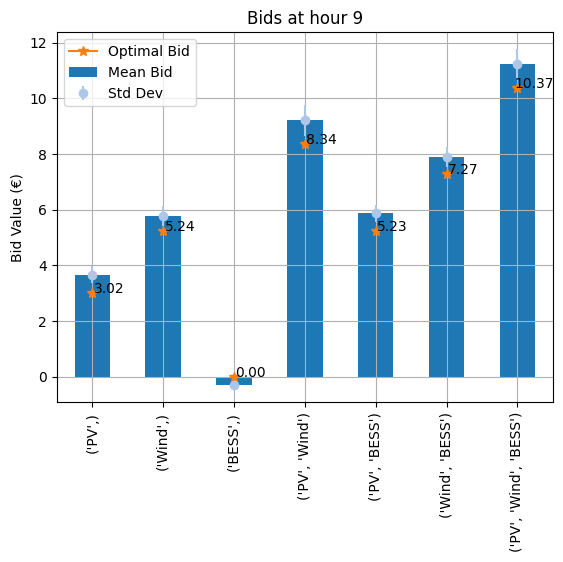

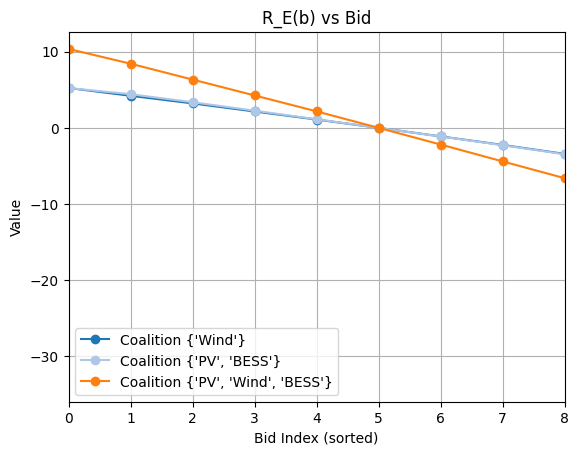

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 11:00:00, optimal partition is [frozenset({'Wind', 'BESS'}), frozenset({'PV'})] with value 17.56902.
Coalition frozenset({'Wind', 'BESS'}) max value at index 0, bid: 6.618, value: 6.618
Coalition frozenset({'PV'}) max value at index 0, bid: 3.359, value: 3.359
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 10.020, value: 10.020


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


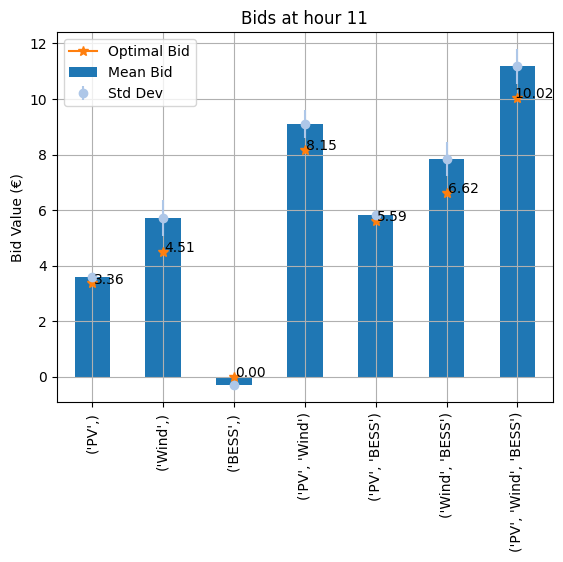

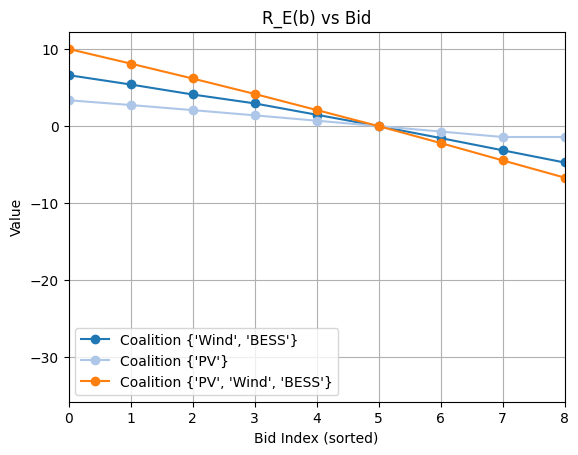

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.173, mean bid: -0.293), submitting 0 bid (not participating).
At hour 2025-04-10 01:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 5.83205.
Coalition frozenset({'Wind'}) max value at index 0, bid: 2.610, value: 2.610
Coalition frozenset({'PV', 'BESS'}) max value at index 18, bid: -0.293, value: 0.761
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 4.763, value: 4.763


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


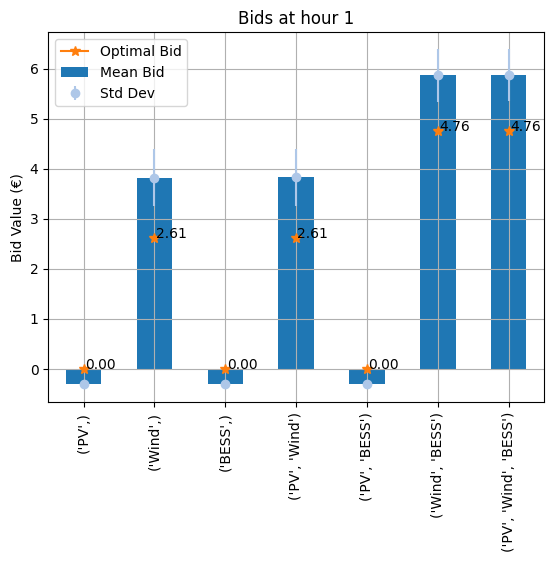

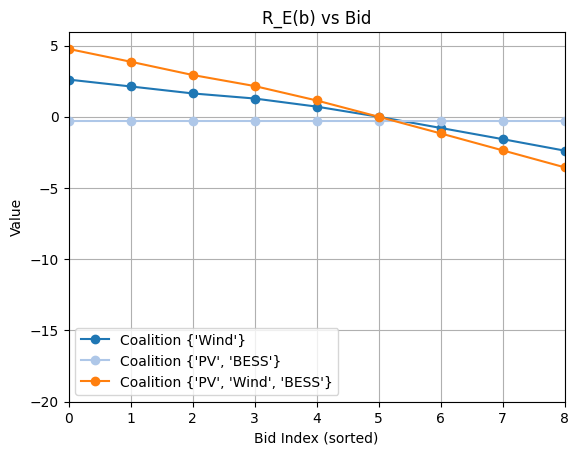

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-10 06:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 17.611359999999998.
Coalition frozenset({'Wind'}) max value at index 2, bid: 0.303, value: 0.182
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 4.484, value: 4.484
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 4.552, value: 4.552


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


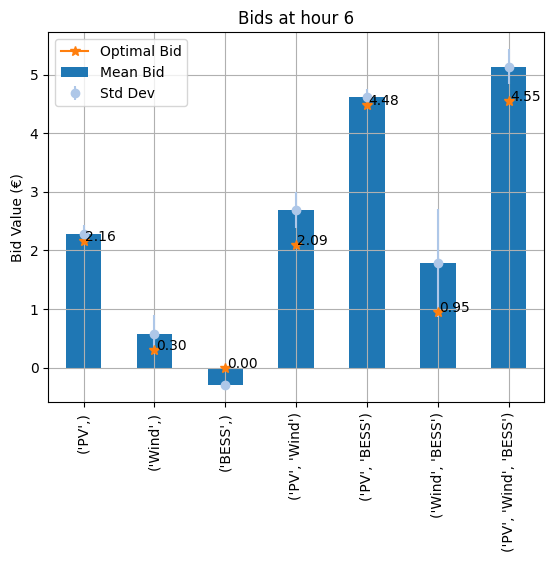

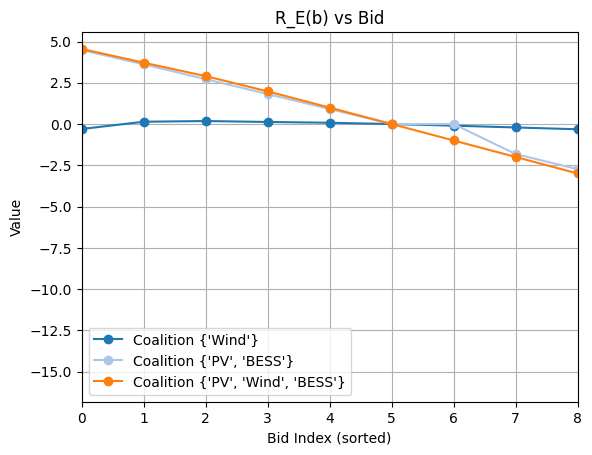

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-10 08:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 6.58089.
Coalition frozenset({'Wind'}) max value at index 2, bid: 0.156, value: 0.094
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 5.454, value: 5.454
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 5.677, value: 5.677


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


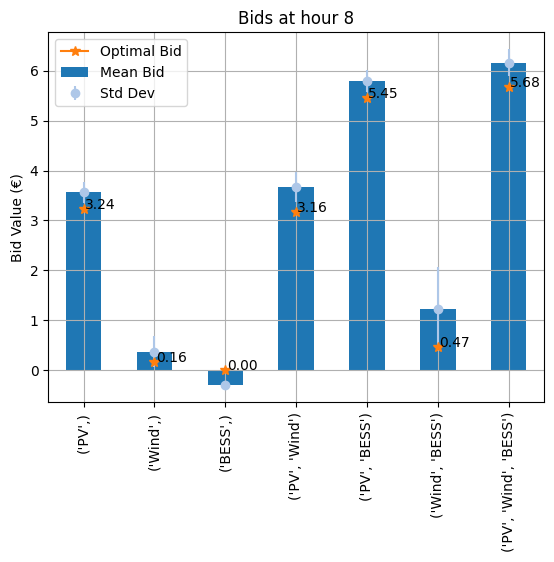

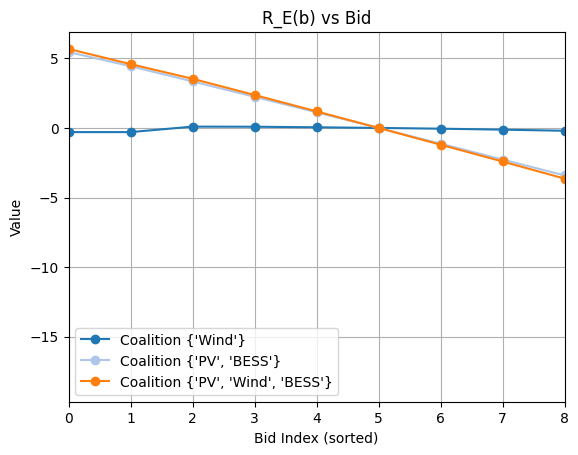

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-10 22:00:00, optimal partition is [frozenset({'Wind', 'BESS'}), frozenset({'PV'})] with value 6.13368.
Coalition frozenset({'Wind', 'BESS'}) max value at index 0, bid: 4.458, value: 4.458
Coalition frozenset({'PV'}) max value at index 0, bid: -0.300, value: -0.300
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 4.458, value: 4.458


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


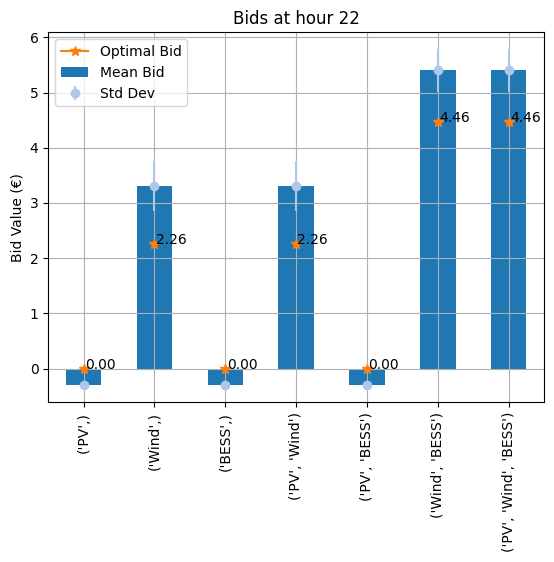

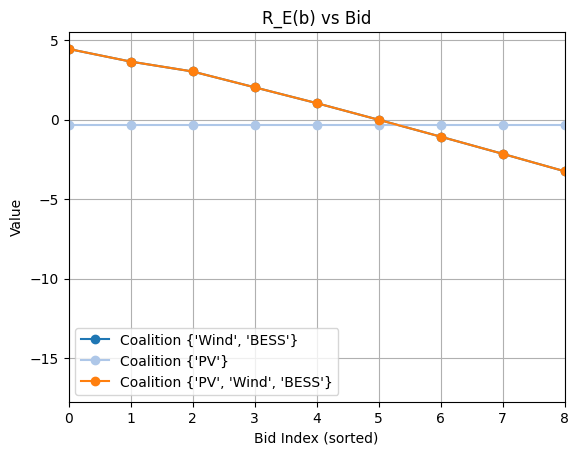

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 00:00:00, optimal partition is [frozenset({'Wind', 'BESS'}), frozenset({'PV'})] with value 4.7914.
Coalition frozenset({'Wind', 'BESS'}) max value at index 0, bid: 4.214, value: 4.214
Coalition frozenset({'PV'}) max value at index 0, bid: -0.300, value: -0.300
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 4.214, value: 4.214


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


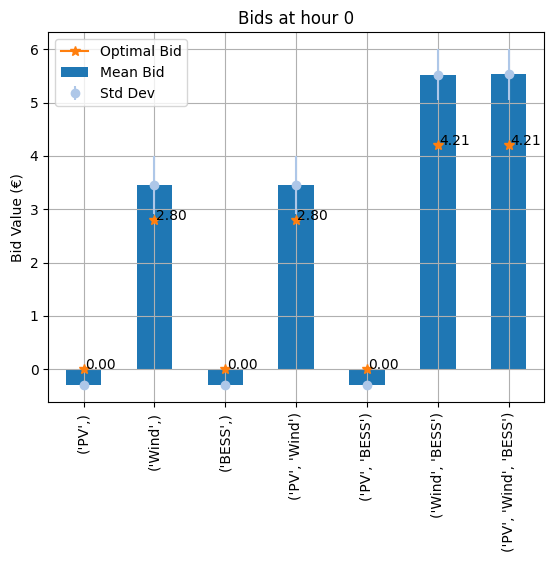

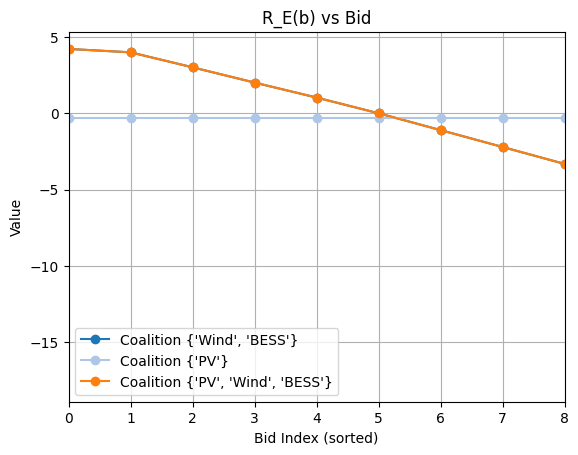

Bids are invalid (max bid: -0.163, mean bid: -0.293), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.121, mean bid: -0.274), submitting 0 bid (not participating).
At hour 2025-04-11 02:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 4.12088.
Coalition frozenset({'Wind'}) max value at index 1, bid: 2.648, value: 2.118
Coalition frozenset({'PV', 'BESS'}) max value at index 18, bid: -0.204, value: 0.530
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 1, bid: 4.798, value: 3.838


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


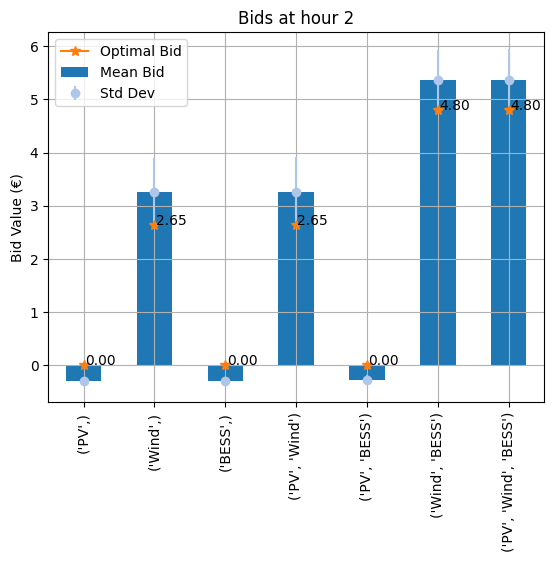

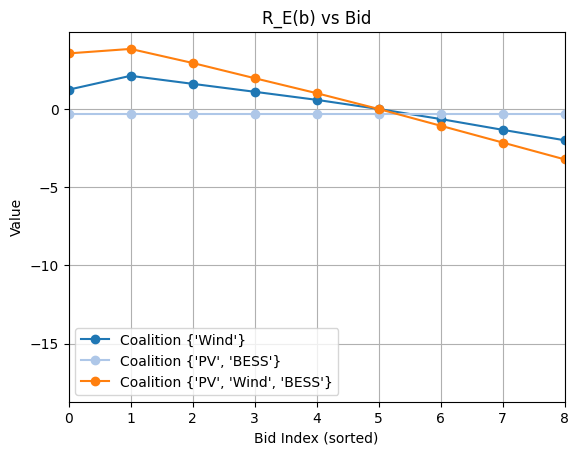

Bids are invalid (max bid: 0.168, mean bid: -0.253), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.412, mean bid: -0.229), submitting 0 bid (not participating).
At hour 2025-04-11 03:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 40.090720000000005.
Coalition frozenset({'Wind'}) max value at index 0, bid: 2.650, value: 2.650
Coalition frozenset({'PV', 'BESS'}) max value at index 17, bid: -0.299, value: 0.718
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 4.749, value: 4.749


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


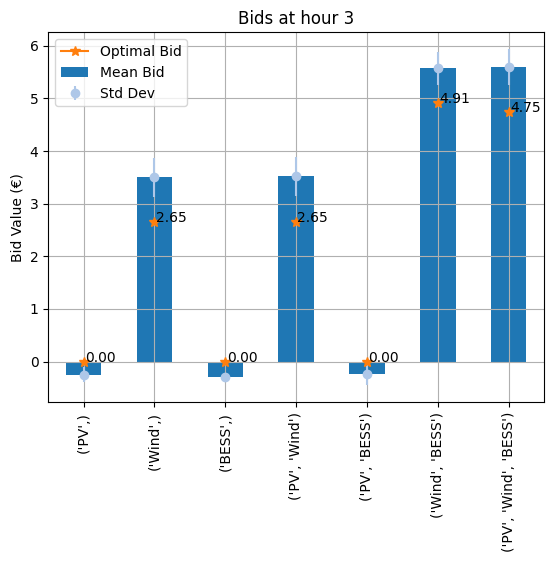

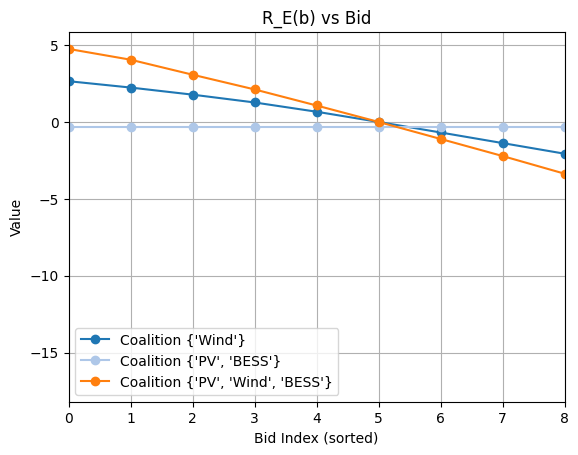

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 06:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 38.21645.
Coalition frozenset({'Wind'}) max value at index 0, bid: 1.298, value: 1.298
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 3.195, value: 3.195
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 5.248, value: 5.248


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


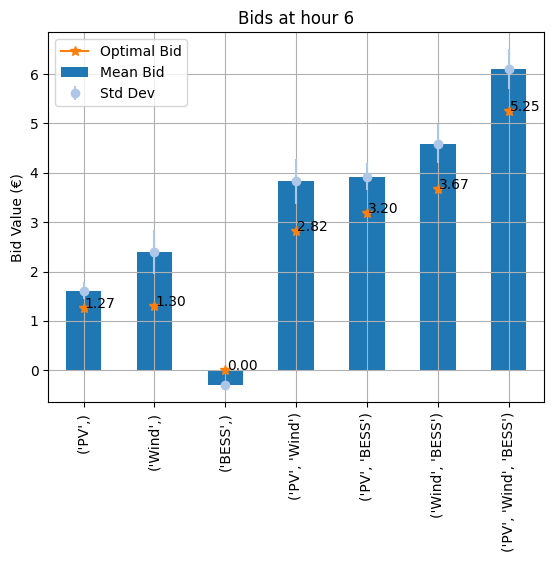

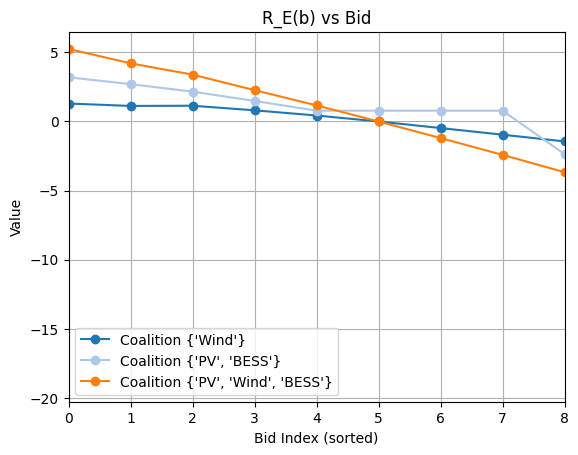

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 08:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 32.54763.
Coalition frozenset({'Wind'}) max value at index 1, bid: 1.992, value: 1.593
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 4.873, value: 4.873
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 6.163, value: 6.163


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


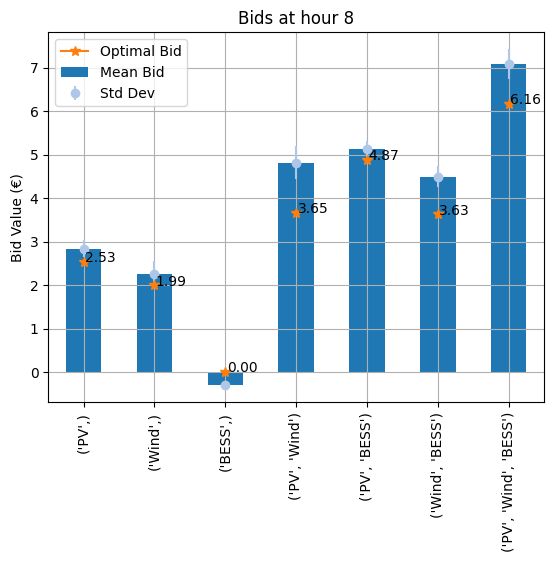

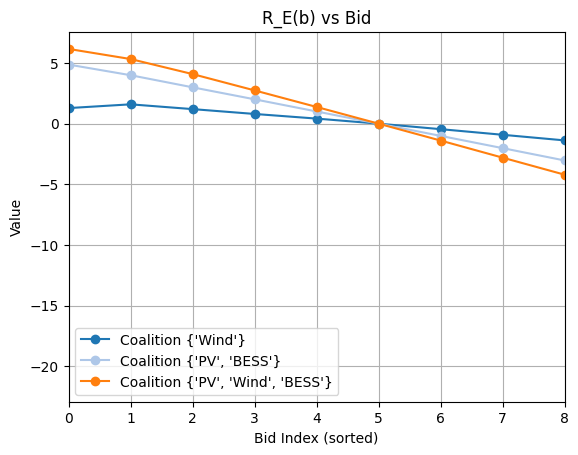

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 09:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 27.961190000000002.
Coalition frozenset({'Wind'}) max value at index 0, bid: 0.910, value: 0.910
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 5.346, value: 5.346
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 6.282, value: 6.282


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


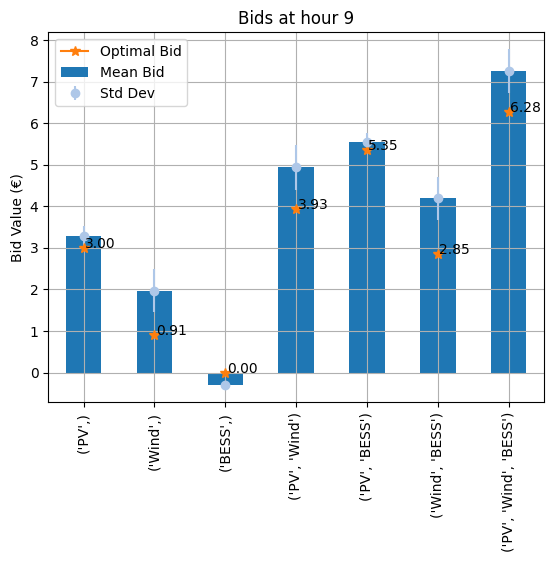

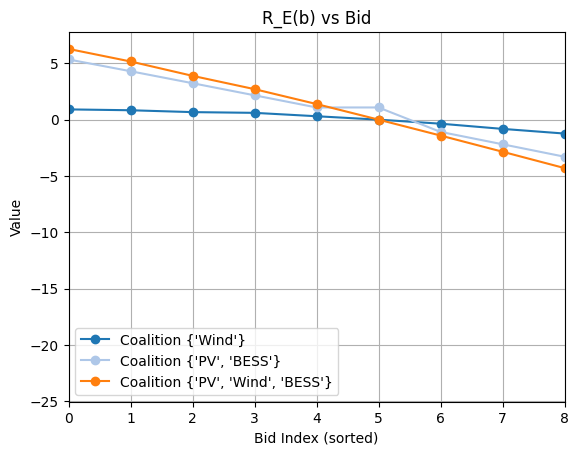

Bids are invalid (max bid: 0.119, mean bid: -0.279), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.278, mean bid: -0.266), submitting 0 bid (not participating).
At hour 2025-04-12 03:00:00, optimal partition is [frozenset({'Wind', 'BESS'}), frozenset({'PV'})] with value 199.82367000000002.
Coalition frozenset({'Wind', 'BESS'}) max value at index 0, bid: 5.800, value: 5.800
Coalition frozenset({'PV'}) max value at index 0, bid: -0.300, value: -0.300
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 5.808, value: 5.808


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


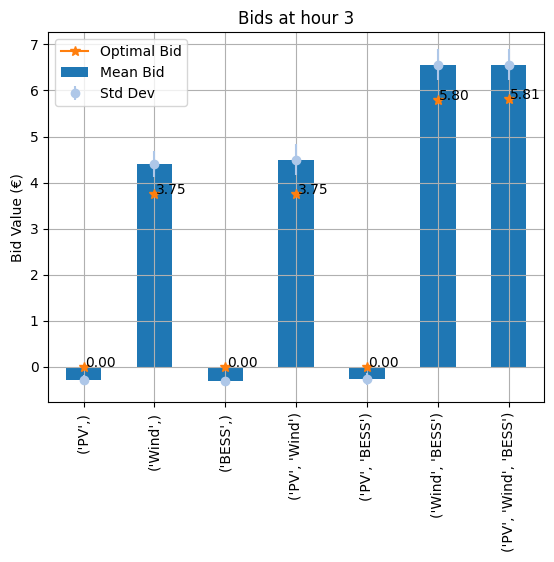

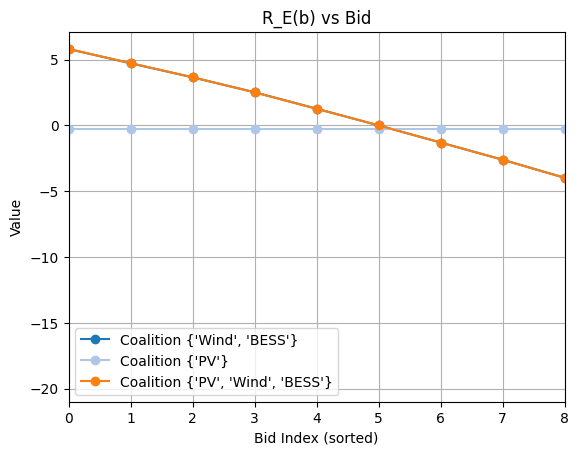

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-12 04:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 208.61282.
Coalition frozenset({'Wind'}) max value at index 0, bid: 3.297, value: 3.297
Coalition frozenset({'PV', 'BESS'}) max value at index 1, bid: 0.265, value: 0.212
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 5.498, value: 5.498


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


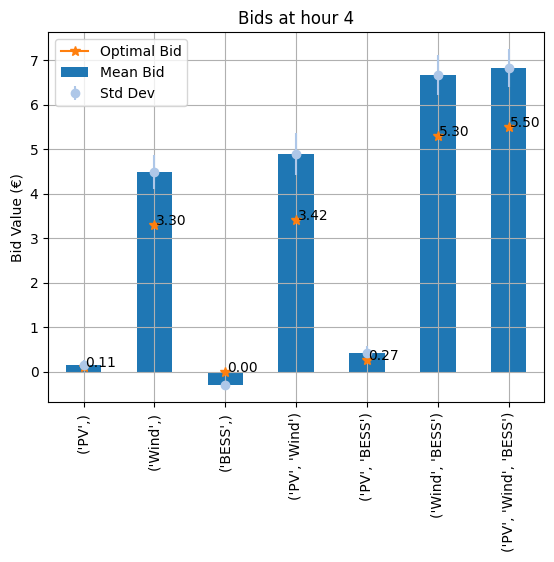

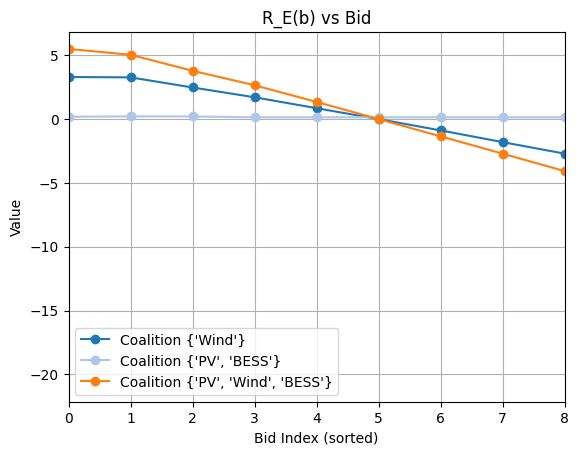

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-12 05:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 236.92938999999998.
Coalition frozenset({'Wind'}) max value at index 0, bid: 3.471, value: 3.471
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 0.341, value: 0.341
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 5.913, value: 5.913


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


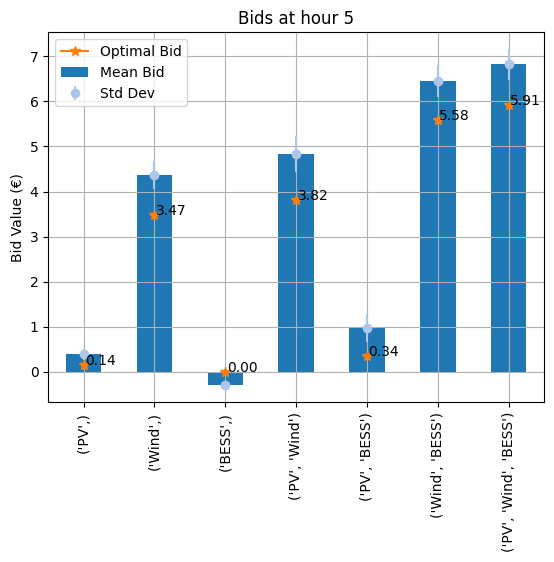

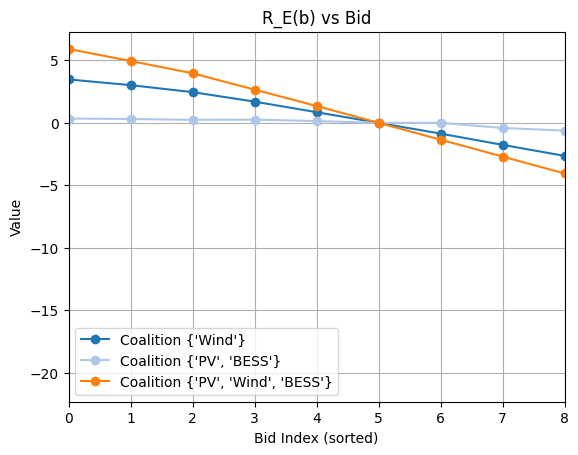

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-12 06:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 215.16870999999998.
Coalition frozenset({'Wind'}) max value at index 1, bid: 3.604, value: 2.883
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 1.630, value: 1.630
Coalition frozenset({'PV', 'Wind', 'BESS'}) max value at index 0, bid: 5.640, value: 5.640


C:\Users\pasca\AppData\Local\Temp\ipykernel_4112\1253627526.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


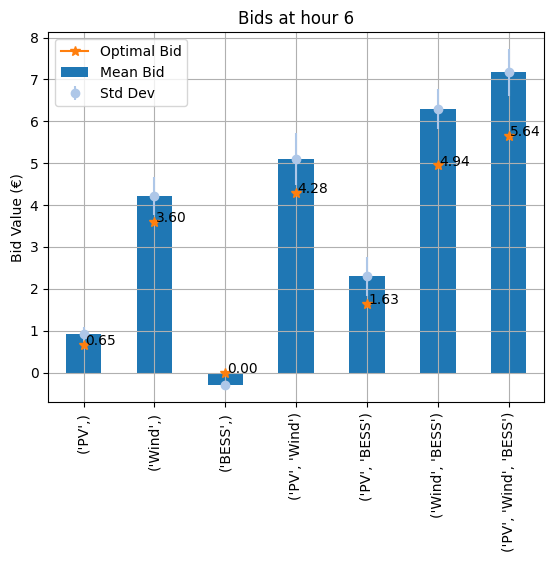

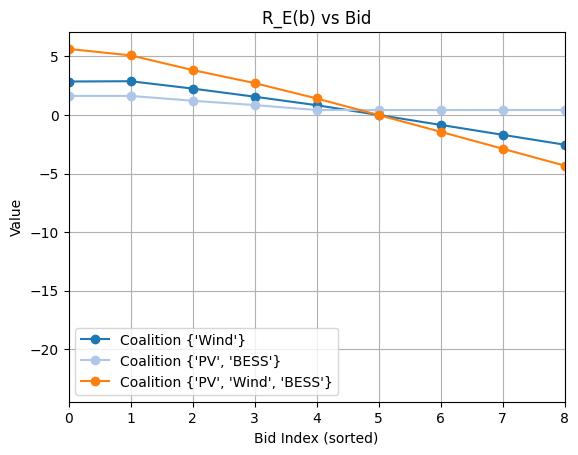

In [65]:
K_errors = len(df_bids.loc[dt_idxs[0]])
probs = [1/K_errors for _ in range(K_errors)]
for dt in dt_idxs:
    # print(dvpps_infos[service].loc[dt])
    # visualize mean and std of each column
    plt.figure()
    plt.title(f'Bids at hour {dt.hour}')
    df_bids.loc[dt].mean(axis=0).plot(kind='bar', label='Mean Bid')
    # plot min max with error bars
    plt.errorbar(x=df_bids.loc[dt].columns, y=df_bids.loc[dt].mean(axis=0), yerr=df_bids.loc[dt].std(axis=0), fmt='o', label='Std Dev',
                 color=base_colors[1])
    # compute optimal bid for each coalition and plot as star marker
    dict_opt_bids = {}
    for coalition in df_bids.loc[dt].columns:
        c_bids = np.squeeze(df_bids.loc[dt, [coalition]].values)
        b_star_coalition, value_wo_price, gamma = get_optimal_bid(c_bids, probs, return_reward=True)
        dict_opt_bids[coalition] = b_star_coalition
        # plot as star marker
        plt.plot(coalition, b_star_coalition, marker='*', markersize=7, label='Optimal Bid' if coalition==df_bids.loc[dt].columns[0] else "", color=base_colors[2])
        # annotate value of optimal bid to the right of the star
        plt.annotate(f'{b_star_coalition:.2f}', (coalition, b_star_coalition), textcoords="offset points", xytext=(12, 0), ha='center', fontsize=10)
    plt.ylabel('Bid Value (€)')
    plt.grid()
    plt.legend()

    # next, also plot th eindividual bids in line chart for non-superadditiv coalitions
    v = {frozenset(k): val for k, val in df_expected.loc[(service, map_datetime_to_idx(dt))].items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    max_value, coalitions = solve_optimal_partition(v)
    print(f'At hour {dt}, optimal partition is {coalitions} with value {max_value}.')
    # plot line chart for this coalition
    plt.figure()
    x_ks = np.arange(K_errors)
    # add grand coalition
    coalitions.append(frozenset(players))

    for coalition in coalitions:
        # convert to columns
        col = the_map[coalition]
        the_bids = df_bids.loc[dt, col].values.tolist()
        the_bids.sort()
        # the_bids = the_bids[::-1]
        # convert bids to values
        vals = bids_to_values(the_bids, probs[0])
        # indicate dict_opt_bids in plot
        plt.plot(x_ks, vals, marker='o', label=f'Coalition {set(coalition)}')
        # print idx and bid of max value
        max_idx = np.argmax(vals)
        print(f"Coalition {coalition} max value at index {max_idx}, bid: {the_bids[max_idx]:.3f}, value: {vals[max_idx]:.3f}")

    plt.xlabel('Bid Index (sorted)')
    plt.ylabel('Value')
    plt.title('R_E(b) vs Bid')
    plt.grid(True)
    plt.xlim((0, 8))
    plt.legend()
    plt.show()

## Plot Examples for Convex, Non-Empty Core and Sub-Coaltiions

In [ ]:
# todo